
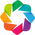

In [118]:
import copy
import numpy as np
import pandas as pd
import holoviews as hv
from daq.pico import CSV
from scipy.optimize import fmin, minimize, basinhopping
from easier import ParamState, shade, Item
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge
hv.extension('bokeh')

In [160]:
%%opts Curve [width=800, height=300]
class Harmonic:
    def __init__(self, freq=1, num_freqs=1, do_freq_fit=True):
        self.num_freqs = num_freqs
        self.init_freq = freq
        self._do_freq_fit = do_freq_fit
        self.sines = np.ones((num_freqs, 1))
        self.cosines = np.ones((num_freqs, 1))
        self.f0 = freq
    
    @property
    def f0(self):
        return self._f0
 
    @f0.setter
    def f0(self, f):
        self._f0 = f
        self._w0 = 2 * np.pi * f

    @property
    def w0(self):
        return self._w0
        
    @w0.setter
    def w0(self, w):
        self._w0 = w
        self._f0 = w / (2 * np.pi)
        
    @property
    def w_array(self):
        return np.array([n * self.w0 for n in range(1, self.num_freqs + 1)])
    
    @property
    def f_array(self):
        return np.array([n * self.f0 for n in range(1, self.num_freqs + 1)])
    
    def derivative(self):
        h = copy.deepcopy(self)
        h.cosines = self.w_array * self.sines
        h.sines = - self.w_array * self.cosines
        return h
    
    def integral(self):
        h = copy.deepcopy(self)
        h.cosines = - self.sines / self.w_array
        h.sines = self.cosines / self.w_array
        return h

    def _fit_freq(self, time, amplitude):
        p = ParamState(
            't',
            'y_true',
            a=1,
            f=self.f0,
            phi=0
        )
        p.given(
            t=time,
            y_true=amplitude
        )

        def model(p):
            return p.a * np.sin(2 * np.pi * p.f * p.t + p.phi)

        def cost(args, p):
            p.ingest(args)
            err = model(p) - p.y_true
            energy = np.sum(err ** 2)
            return energy
    
        
        x0 = p.array
        xf = basinhopping(cost, x0, minimizer_kwargs=dict(args=(p,))).x
        p.ingest(xf)
        if (p.f - self.f0) > 3 ** 2:
            raise ValueError(f'Guess freq: {self.f0}, Fit Freq: {p.f}  too far apart')
        self.f0 = p.f
        
    def _get_bases(self, time):
        if not isinstance(time, np.ndarray):
            time = np.array(time)
        df_cos = pd.DataFrame(index=range(len(time)))
        df_sin = pd.DataFrame(index=range(len(time)))

        for n, w in enumerate(self.w_array):
            df_sin.loc[:, n] = np.sin(w * time)
            df_cos.loc[:, n] = np.cos(w * time)
            
        sin_bases, cos_bases = df_sin.values, df_cos.values
        return np.append(sin_bases, cos_bases, axis=1)
        

    def _fit_params(self, times, values):
        basis = self._get_bases(times)

        # in case you want to do ridge regression
        # alpha = .000002
        # model_res = Ridge(alpha=alpha)

        # in case you want to do just linear regression
        model = LinearRegression()

        model.fit(basis, values)
        self.sines = model.coef_[:self.num_freqs]
        self.cosines = model.coef_[self.num_freqs:]
        return model.coef_
    
    def fit(self, times, values):
        if self._do_freq_fit:
            self._fit_freq(times, amplitude)
        self._fit_params(times, values)
        
    
    def predict(self, t):
        # use mat mult to get args to trig funcs
        phi = np.matrix(t).T * np.matrix(self.w_array)
        
        # use mat mult to multiply by coeffs
        cosine_terms = np.cos(phi) * np.matrix(self.cosines).T
        sine_terms = np.sin(phi) * np.matrix(self.sines).T
        
        # cast to arrays
        cosine_terms = np.asarray(cosine_terms)
        sine_terms = np.asarray(sine_terms)
        
        # sum terms to get prediction
        prediction = np.sum(cosine_terms, axis=1)
        prediction += np.sum(sine_terms, axis=1)
        
        # return squeezed prediction
        return np.squeeze(prediction)
                            
        
  
    
    
    
    
    
        

freq = 20
omega = 2 * np.pi * freq
t = np.linspace(0, 1 * np.pi, 10000)
y = 3 * np.cos(2 * np.pi * freq * t)
y += 10 * np.sin(2 * np.pi * 2*freq * t)


h = Harmonic(freq=freq, num_freqs=2, do_freq_fit=False)
h.fit(t, y)
hd = h.derivative()
hh = hd.integral()

yd = np.diff(y) / np.median(np.diff(t))
td = t[1:]
# hv.Curve((td, yd / omega), label='deriv') * hv.Curve((t, y), label='orig')

(
    hv.Curve((td, yd), label='approx') * hv.Curve((td, hd.predict(td)), label='analytic')
    + hv.Curve((t, y), label='orig') * hv.Curve((t, hh.predict(t) + .1), label='cycled')
).cols(1)
    

# print(hd.sines / hd.w_array)
# print(h.cosines)
# print()
# print(hd.cosines / hd.w_array)
# print(h.sines)
# hd.cosines / hd.w_array - h.sines
# hd.sines / hd.w_array + h.cosines




:Layout
   .Overlay.I  :Overlay
      .Curve.Approx   :Curve   [x]   (y)
      .Curve.Analytic :Curve   [x]   (y)
   .Overlay.II :Overlay
      .Curve.Orig   :Curve   [x]   (y)
      .Curve.Cycled :Curve   [x]   (y)

In [151]:

# hv.Curve((td, yd), label='approx') * hv.Curve((t, y), label='calc')
omega

125.66370614359172

In [128]:
%%opts Curve [width=800, height=300]
(
    hv.Curve((t, y), vdims=['v1'])
    + hv.Curve((t, hd.predict(t) + .1), vdims=['v2'])
#     * hv.Curve((t, xxx[:, 1]))
).cols(1)


:Layout
   .Curve.I  :Curve   [x]   (v1)
   .Curve.II :Curve   [x]   (v2)

In [108]:
xxx = np.matrix([[np.pi, np.pi/2], [3 * np.pi / 4, -np.pi / 3]])

In [109]:
np.sin(xxx)

matrix([[  1.22464680e-16,   1.00000000e+00],
        [  7.07106781e-01,  -8.66025404e-01]])